# ***Proving the Quantum Routing Advantage***

***Phase 2 Objective: The Interference Hypothesis***


In Phase 1, we established that Classical Mixture of Experts (MoE) dominate on simple, linearly separable data. To see where Quantum MoE (QMoE) shines, we need a problem that breaks linear logic.

The **Hypothesis**: A Classical Gating network uses linear partitions (straight cuts) to route data. It struggles with "entangled" or non-convex shapes. A Quantum Gating network projects data into a high-dimensional Hilbert space (via feature maps) and uses wave interference to route data. This should allow it to separate complex, interlocking shapes with fewer parameters.

The Experiment:

* Dataset: "Two Moons" (Interlocked non-linear data).

* Model A (Control): Classical MoE with a Linear Router.

* Model B (Test): Hybrid QMoE with a Quantum Router.

Success Metric: Visualizing the Decision Boundary. We expect the Quantum Router to "curve" around the data naturally, while the Classical Router creates jagged, straight cuts

In [5]:
# Install PennyLane and the accelerated lightning plugin for fast simulation
!pip install pennylane torch matplotlib scikit-learn
!pip install pennylane-lightning

import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

# Enable CUDA if available, else use optimized CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
def get_moons_data(n_samples=500):
    X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

    # Rescale to [0, pi]
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_scaled = (X - X_min) / (X_max - X_min) * np.pi

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.long).to(device)

    return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True), X_tensor.cpu(), y_tensor.cpu()

# !!! THIS IS THE LINE THAT DEFINES 'train_loader' !!!
train_loader, X_vis, y_vis = get_moons_data()

***Model A: The Classical Control***

We define a standard Classical Mixture of Experts.

* Router: A single Linear layer + Softmax. This decides which expert gets the

  data based on a linear decision boundary (a straight line).

* Experts: Simple Linear Classifiers.

* Goal: We want to see how a "Linear Router" fails to capture the moon shape.

In [7]:
class ClassicalGatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        # Classical gating: Linear decision boundary
        self.layer = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        return torch.softmax(self.layer(x), dim=1)

class ClassicalMoE(nn.Module):
    def __init__(self, input_dim, num_experts, output_dim):
        super().__init__()
        self.router = ClassicalGatingNetwork(input_dim, num_experts)
        # Experts are simple Linear classifiers
        self.experts = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(num_experts)])

    def forward(self, x):
        routing_weights = self.router(x)
        expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        # Weighted sum of expert outputs
        output = torch.einsum('be,beo->bo', routing_weights, expert_outputs)
        return output

***Model B: The Quantum Router (QMoE)***

Here we implement the core hypothesis. We replace the Linear Router with a Quantum Router.

* Feature Map (AngleEmbedding): Maps the data inputs to quantum rotations. This is where the non-linearity comes from (since rotations are trigonometric).

* Ansatz (StronglyEntanglingLayers): A parameterized circuit that uses entanglement (CNOTs) to mix information between qubits.

* Measurement: We measure the qubits to get routing probabilities.

Note: We keep the Experts classical. If this model performs better or draws a better boundary, it is purely because the Quantum Router understood the geometry of the data better than the Classical Router.

In [8]:
n_qubits = 2  # Minimized for speed on Colab
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def quantum_router_circuit(inputs, weights):
    # 1. Feature Map: Map data x,y to rotation angles (Non-linear transformation)
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # 2. Ansatz: The learning part (Rotations + Entanglements)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # 3. Measurement: Return expectation values to act as routing probabilities
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumRouter(nn.Module):
    def __init__(self, n_experts):
        super().__init__()
        # 3 Layers of entanglement
        weight_shapes = {"weights": (3, n_qubits, 3)}
        self.qnode = qml.qnn.TorchLayer(quantum_router_circuit, weight_shapes)

        # Adapter layer to map Qubit outputs to Expert probabilities
        self.adapter = nn.Linear(n_qubits, n_experts)

    def forward(self, x):
        q_out = self.qnode(x)
        return torch.softmax(self.adapter(q_out), dim=1)

class HybridQMoE(nn.Module):
    def __init__(self, input_dim, num_experts, output_dim):
        super().__init__()
        self.router = QuantumRouter(num_experts)
        # Same simple classical experts as Model A
        self.experts = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(num_experts)])

    def forward(self, x):
        routing_weights = self.router(x)
        expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        output = torch.einsum('be,beo->bo', routing_weights, expert_outputs)
        return output

***Training Loop***

We will now train both models on the Two Moons dataset. We use the standard Adam optimizer and Cross Entropy Loss.

Observation Step: Watch the loss values. The QMoE might start with higher loss (random quantum state) but should converge to a solution that fits the data's curve better.

In [9]:
def train_and_evaluate(model, loader, epochs=50, lr=0.1):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(loader))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {epoch_loss:.4f}")

    return loss_history

# --- Run Experiments ---
print("--- Training Classical MoE ---")
c_moe = ClassicalMoE(input_dim=2, num_experts=2, output_dim=2).to(device)
c_hist = train_and_evaluate(c_moe, train_loader)

print("\n--- Training Hybrid QMoE (Quantum Router) ---")
q_moe = HybridQMoE(input_dim=2, num_experts=2, output_dim=2).to(device)
q_hist = train_and_evaluate(q_moe, train_loader)

--- Training Classical MoE ---
Epoch 0: Loss 5.5273
Epoch 10: Loss 4.1263
Epoch 20: Loss 4.0466
Epoch 30: Loss 4.0926
Epoch 40: Loss 4.0851

--- Training Hybrid QMoE (Quantum Router) ---
Epoch 0: Loss 5.1472
Epoch 10: Loss 1.0519
Epoch 20: Loss 1.1856
Epoch 30: Loss 0.4430
Epoch 40: Loss 0.2978


***Visualization: The "Smoking Gun"***

This is the most important part of Phase 2. We will generate a Decision Boundary Plot.

Classical Expectation: You should see straight lines cutting through the moons. The model will likely fail to classify the "tips" of the crescents correctly because a straight line cannot separate interlocked C-shapes.

Quantum Expectation: You should see a curved decision boundary. The quantum feature map (Angle Embedding) allows the router to create non-linear separation zones.

If you see curves in the QMoE plot and straight lines in the Classical plot, you have confirmed the hypothesis.

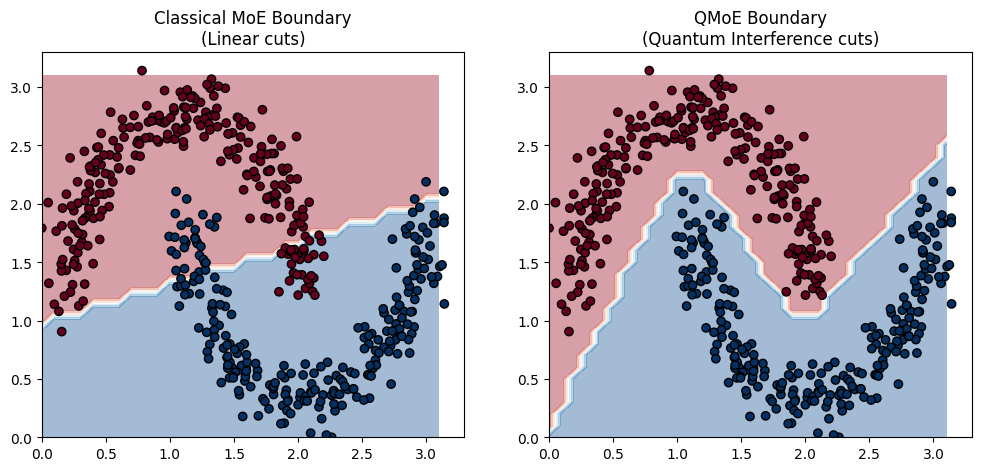

In [10]:
def plot_decision_boundary(model, title):
    # Define meshgrid covering the input space [0, pi]
    x_min, x_max = 0, np.pi
    y_min, y_max = 0, np.pi
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict across the entire grid
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    with torch.no_grad():
        Z = model(grid_tensor).argmax(dim=1).cpu().numpy()

    Z = Z.reshape(xx.shape)

    # Plot contours
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap='RdBu', edgecolors='k')
    plt.title(title)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(c_moe, "Classical MoE Boundary\n(Linear cuts)")
plt.subplot(1, 2, 2)
plot_decision_boundary(q_moe, "QMoE Boundary\n(Quantum Interference cuts)")
plt.show()